In [42]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
from PIL import Image
import tensorflow.compat.v1 as tfc
%matplotlib inline

I will follow the implementation used in this https://arxiv.org/abs/1508.06576 paper.



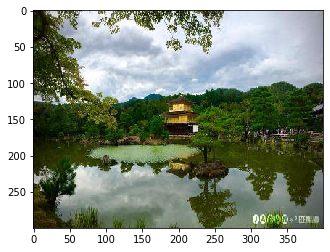

In [23]:
content_image = Image.open('japanese_garden2.jpg')
imshow(content_image)

In [32]:
def compute_content_cost(a_C, a_G): # Difference between activations
    # Retrieving dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping a_C and a_G
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
    # Computation of cost
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))
    
    return J_content

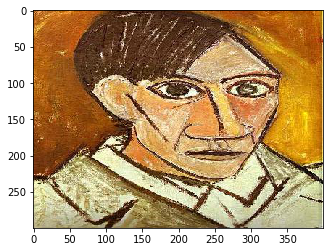

In [22]:
style_image = Image.open("picasso_selfportrait2.jpg")
imshow(style_image);

In [25]:
#Calculating gram matrix for style image cost
def gram_matrix(A):
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [33]:
def compute_layer_style_cost(a_S, a_G):
    #Retrieving the dimensions
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping the images 
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    # Computing gram matrices for both Style and Generated image 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    # Computation of loss
    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    
    return J_style_layer

Computing loss from more than one layer makes styling of image more easy

In [34]:
# Different Layers
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [26]:
def compute_style_cost(model, STYLE_LAYERS):
    
    # initializing the style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Selecting the output tensor of the currently selected layer
        out = model[layer_name]

        # Setting hidden layer activation from the layer selected
        a_S = sess.run(out)

        # Setting a_G as the hidden layer activation from same layer
        a_G = out
        
        # Computing style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Accumulating the cost
        J_style += coeff * J_style_layer
        
    return J_style


In [35]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha*J_content + beta*J_style

    return J

In [39]:
#tf.reset_default_graph()
tf.compat.v1.get_default_graph

sess = tfc.InteractiveSession()

In [ ]:
content_image = scipy.misc.imread("japanese_garden2.jpg")
content_image = reshape_and_normalize_image(content_image)

In [ ]:
style_image = scipy.misc.imread("picasso_selfportrait2.jpg")
style_image = reshape_and_normalize_image(style_image)

Creating random noise for generated image

In [ ]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

For the following code block you need to download the pretrained model from this link http://www.vlfeat.org/matconvnet/pretrained/. 

In [ ]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [ ]:
sess.run(model['input'].assign(content_image))

out = model['conv4_2']

a_C = sess.run(out)

a_G = out

J_content = compute_content_cost(a_C, a_G)

In [ ]:
sess.run(model['input'].assign(style_image))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [ ]:
J = total_cost(J_content,J_style,10,40)

In [ ]:
optimizer = tf.train.AdamOptimizer(2.0) # Learning rate of 2.0

train_step = optimizer.minimize(J)


In [ ]:
def model_nn(sess, input_image, num_iterations = 500):
    
    # Initializing global variables
    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # saving current generated image in this directory
            save_image( str(i) + ".png", generated_image)
    
    # saving last generated image
    save_image('generated_image.jpg', generated_image)
    
    return generated_image
# Generted image is in the form of tensor

It takes almost 5 minutes for 20 iterations

In [ ]:
model_nn(sess, generated_image)

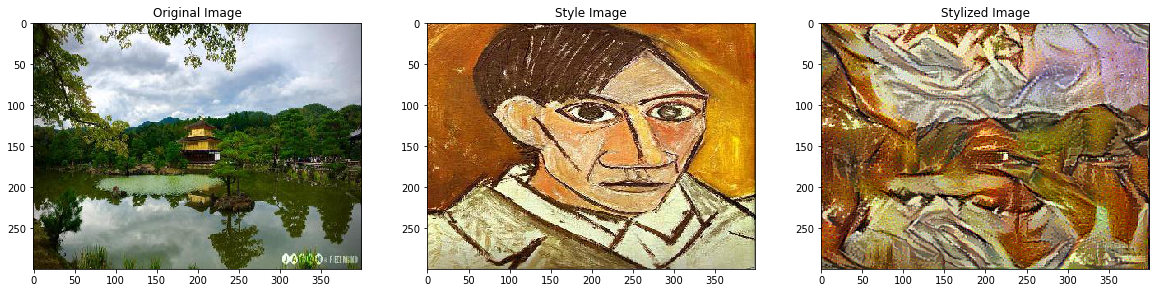

In [31]:
generated_image = Image.open("generated_image.png")
fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(content_image)
t1 = ax1.set_title('Original Image')

ax1 = fig.add_subplot(1,3,2)
ax1.imshow(style_image)
t1 = ax1.set_title('Style Image')

ax1 = fig.add_subplot(1,3,3)
ax1.imshow(generated_image)
t1 = ax1.set_title('Stylized Image')

Thank you!